In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import minmax_scale
import numpy as np

## Read files

In [2]:
file_path = '2000 iterations/gsa_results.xlsx'
sheet_name_gsa = 'GSA'
sheet_name_mapping = 'Indices mapping'

df_gsa = pd.read_excel(file_path, sheet_name=sheet_name_gsa)
df_gsa = df_gsa[df_gsa['LCIA method'] != 'RELICS - metals extraction - Palladium']
df_mapping = pd.read_excel(file_path, sheet_name=sheet_name_mapping)

## Clean data and improve readability

In [3]:
product_mapping_dict = df_mapping.set_index('Value')['Product'].to_dict()
name_mapping_dict = df_mapping.set_index('Value')['Name'].to_dict()

lcia_method_mapping = {
    'EF v3.1 EN15804 - climate change - global warming potential (GWP100)':'Global warming potential',
    'ReCiPe 2016 v1.03, midpoint (H) - particulate matter formation - particulate matter formation potential (PMFP)':'Particulate matter formation',
    'EF v3.1 EN15804 - acidification - accumulated exceedance (AE)': 'Acidification',
    'EF v3.1 EN15804 - ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)':'Ecotoxicity: freshwater',
    'Inventory results and indicators - resources - total surface occupation':'Land use',
    'ReCiPe 2016 v1.03, midpoint (H) - water use - water consumption potential (WCP)': 'Water use',
    'Crustal Scarcity Indicator 2020 - material resources: metals/minerals - crustal scarcity potential (CSP)':'Crustal scarcity indicator',
    'EF v3.1 EN15804 - material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)': 'Abiotic depletion potential',
    'RELICS - metals extraction - Lithium':'Lithium extraction',
    'RELICS - metals extraction - Cobalt':'Cobalt extraction',
    'RELICS - metals extraction - Vanadium':'Vanadium extraction',
    'RELICS - metals extraction - Platinum':'Platinum extraction',
    'RELICS - metals extraction - Silver':'Silver extraction',
    'RELICS - metals extraction - Iridium':'Iridium extraction',
    'RELICS - metals extraction - Neodymium':'Neodymium extraction',
    'RELICS - metals extraction - Gallium':'Gallium extraction',
    'RELICS - metals extraction - Sulfur':'Sulfur extraction'
}

In [4]:
# Function to map "int::int" to "PRODUCT -> NAME"
def map_parameter(param):
    try:
        parts = param.split('::')
        product = product_mapping_dict.get(int(parts[0]), f"Unknown product {parts[0]}")
        name = name_mapping_dict.get(int(parts[1]), f"Unknown name {parts[1]}")
        return f"{product} -> {name}"
    except:
        return param

In [5]:
df_gsa['Parameter'] = df_gsa['Parameter'].apply(map_parameter)
df_gsa['LCIA method'] = df_gsa['LCIA method'].map(lcia_method_mapping).fillna(df_gsa['LCIA method'])

# Replace negative delta values with zero
df_gsa['Delta'] = df_gsa['Delta'].clip(lower=0)

In [6]:
df_gsa['Delta_normalized'] = df_gsa.groupby('LCIA method')['Delta'].transform(lambda x: minmax_scale(x))

## Plot

### 1. Above 0.9 (main text)

In [7]:
# Filter the parameters where the normalized delta values are above 0.9
filtered_df = df_gsa[df_gsa['Delta_normalized'] > 0.9]

# Pivot the dataframe to prepare for heatmap
heatmap_data = filtered_df.pivot_table(index='Parameter', columns='LCIA method', values='Delta', aggfunc='first')
# Remove rows where all Delta values are NaN
heatmap_data = heatmap_data.dropna(how='all')
heatmap_data = heatmap_data.dropna(axis=1, how='all')

ordered_lcia_methods = [lcia_method_mapping[key] for key in lcia_method_mapping]
heatmap_data = heatmap_data.reindex(columns=ordered_lcia_methods)

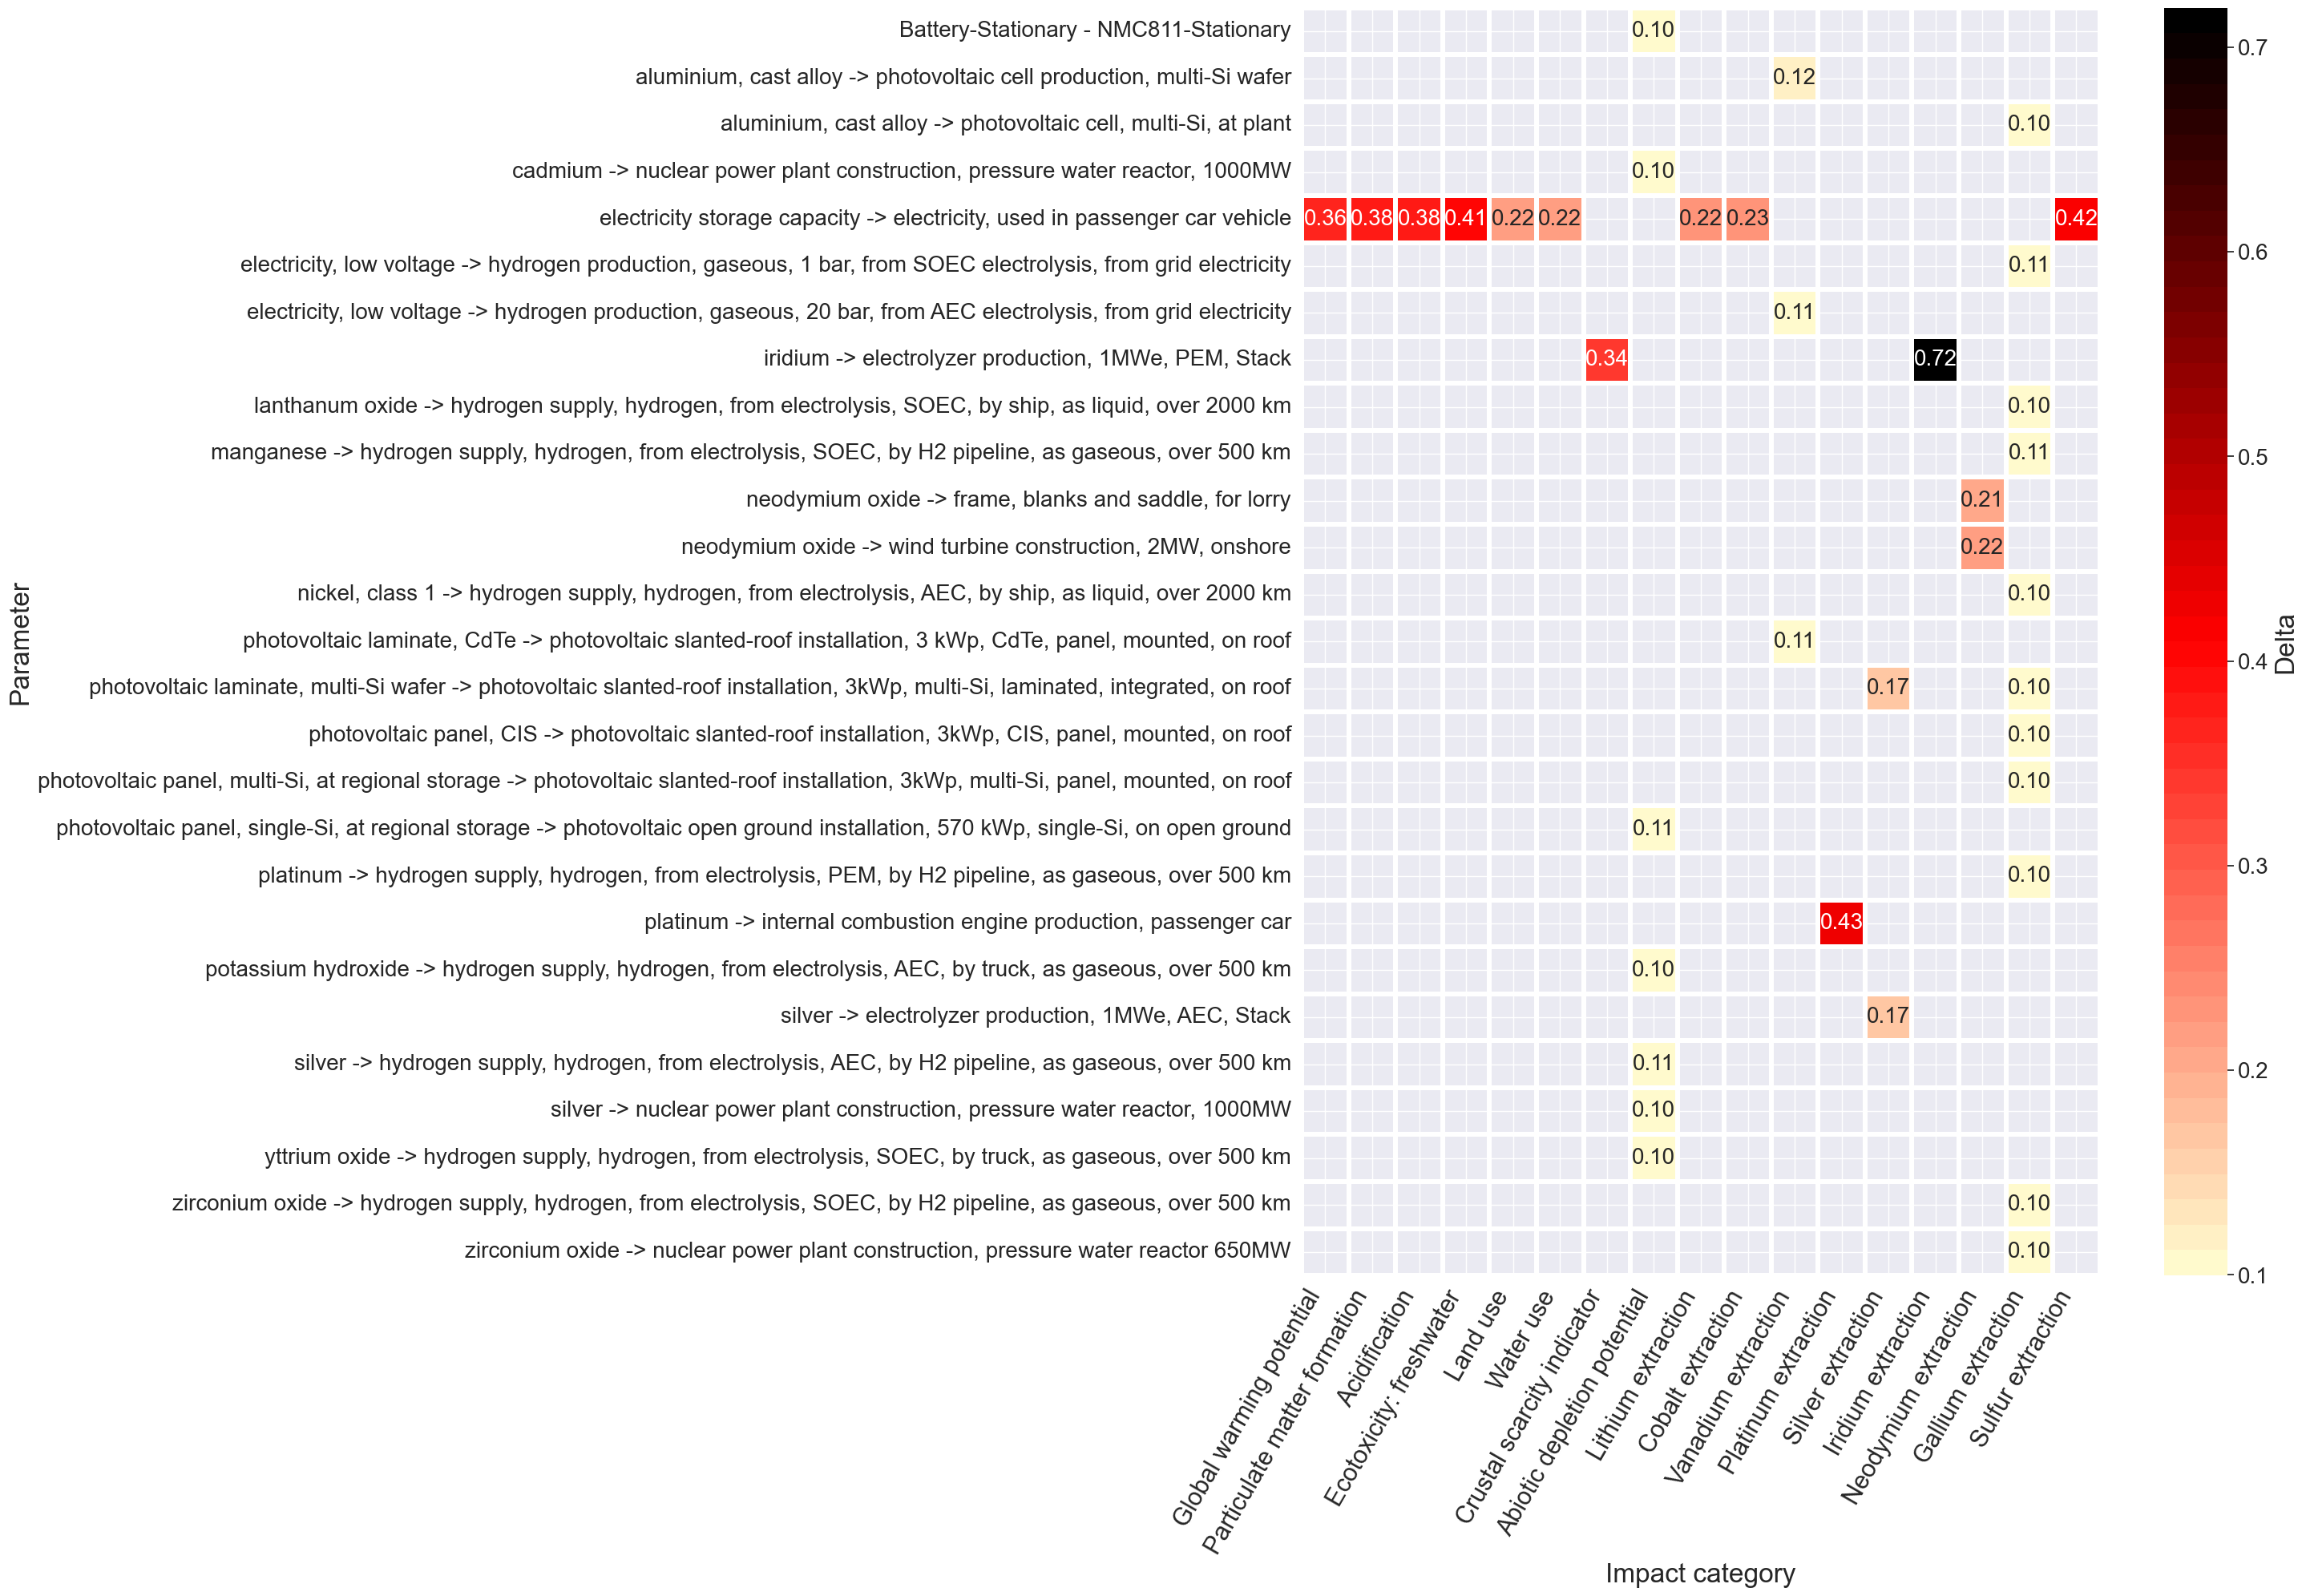

In [8]:
# Create a custom colormap (white to yellow to red)
colors = ['lemonchiffon', 'red', 'black']
n_bins = 50  # Number of bins for the colormap
cmap_name = 'white_yellow_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot the heatmap with relevant parameters using original Delta values
plt.figure(figsize=(26, 20))  # Increase figure size
sns.set(font_scale=0.8)  # Adjust font scale
ax = sns.heatmap(heatmap_data, annot=True, cmap=cm, cbar_kws={'label': 'Delta'}, annot_kws={"size": 20}, fmt='.2f', square=True, linewidths=3)

# Keep y-tick labels in the original place
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=20)  # Labels stay in their original positions

# Customize color bar tick size
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)  # Set colorbar ticks font size
colorbar.set_label('Delta', size=24)

# Title and labels
# plt.title('Heatmap of Delta Values (Most Relevant Parameters)', fontsize=20)
plt.xlabel('Impact category', fontsize=24)
plt.ylabel('Parameter', fontsize=24)
plt.xticks(rotation=60, ha='right', fontsize=22)

plt.tight_layout()
plt.savefig('Figure_4_GSA_heatmap_90.svg',bbox_inches='tight')
# Show the heatmap
plt.show()

### 2. Above 0.75 (Supplementary material)

In [9]:
# Filter the parameters where the normalized delta values are above 0.75
filtered_df = df_gsa[df_gsa['Delta_normalized'] > 0.80]

# Pivot the dataframe to prepare for heatmap
heatmap_data = filtered_df.pivot_table(index='Parameter', columns='LCIA method', values='Delta', aggfunc='first')

ordered_lcia_methods = [lcia_method_mapping[key] for key in lcia_method_mapping]
heatmap_data = heatmap_data.reindex(columns=ordered_lcia_methods)

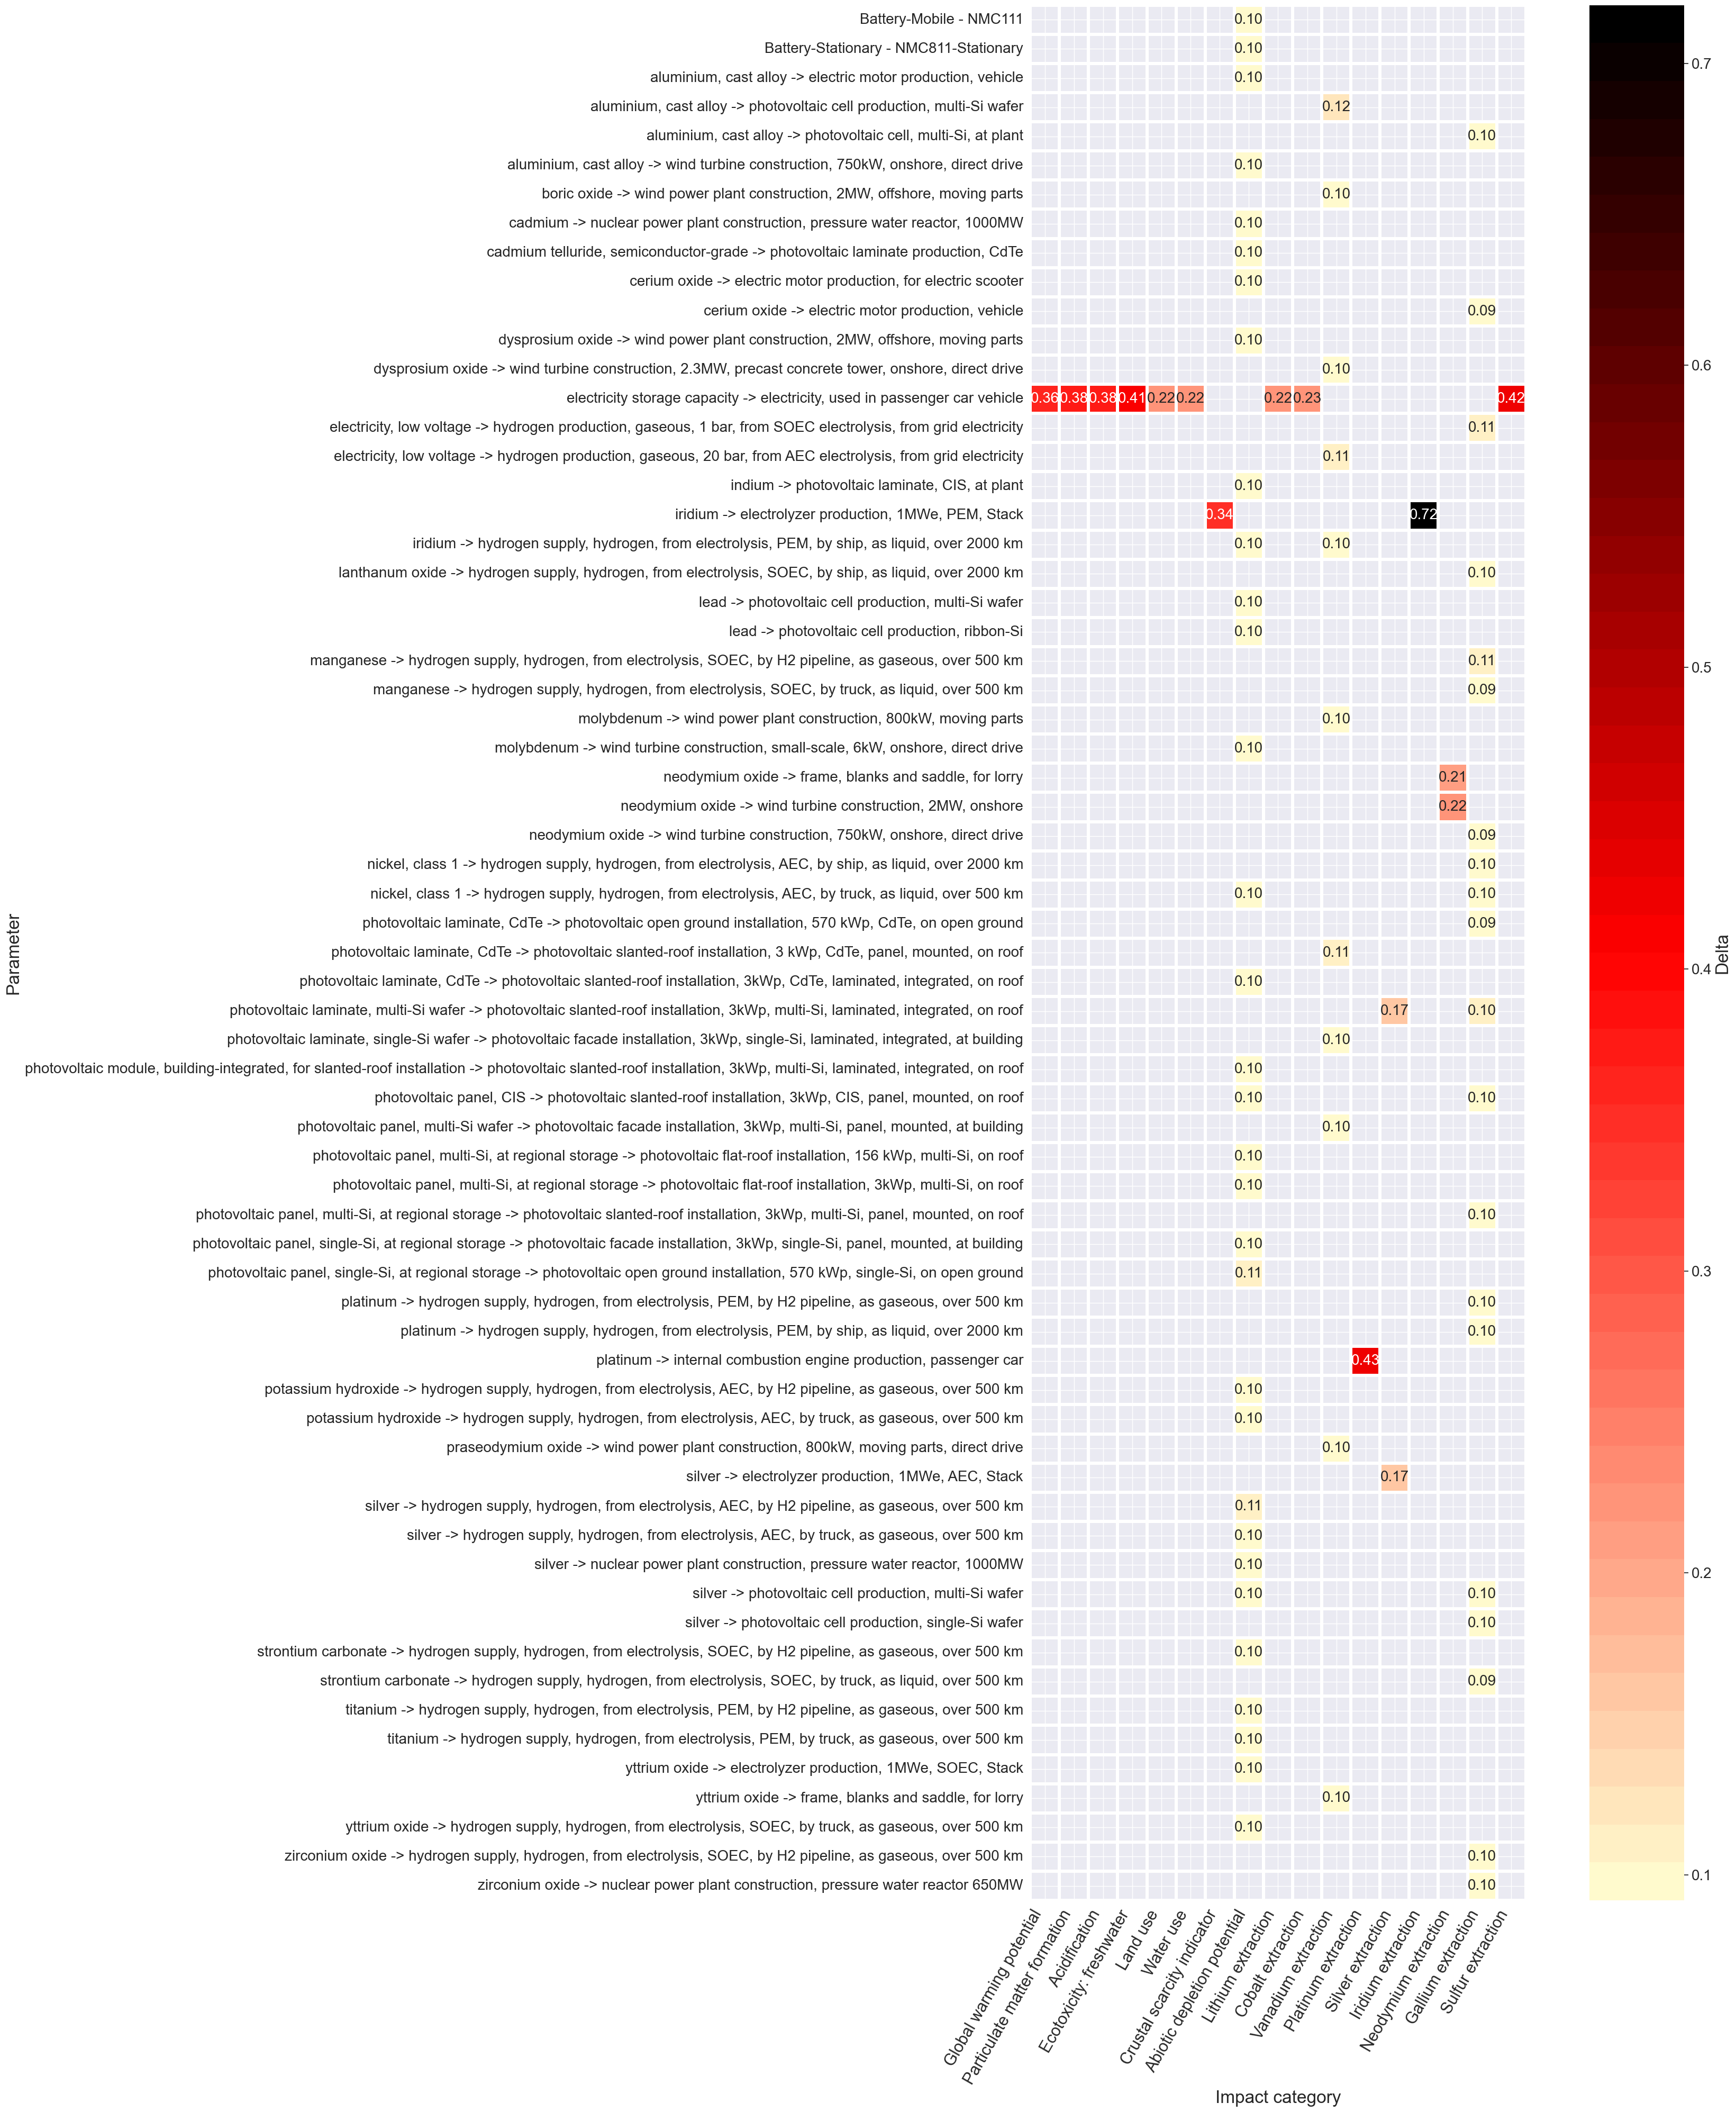

In [10]:
colors = ['lemonchiffon', 'red', 'black']
n_bins = 50  # Number of bins for the colormap
cmap_name = 'white_yellow_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(32, 40))  # Increase figure size
sns.set(font_scale=0.8)  # Adjust font scale
ax = sns.heatmap(heatmap_data, annot=True, cmap=cm, cbar_kws={'label': 'Delta'}, annot_kws={"size": 20}, fmt='.2f', square=True, linewidths=3)


ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=20)  

colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)  # Set colorbar ticks font size
colorbar.set_label('Delta', size=24)



plt.xlabel('Impact category', fontsize=24)
plt.ylabel('Parameter', fontsize=24)
plt.xticks(rotation=60, ha='right', fontsize=22)

plt.tight_layout()
plt.savefig('Figure_5_GSA_heatmap_80.svg',bbox_inches='tight')

plt.show()